In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.image import ImageDataGenerator

E0000 00:00:1746518672.545453      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [2]:
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_path = "/kaggle/input/german-traffic-sign-recognition-benchmark/train"
val_path = '/kaggle/input/german-traffic-sign-recognition-benchmark/val'
test_path = '/kaggle/input/german-traffic-sign-recognition-benchmark/test'

In [4]:
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(32, 32),        
    batch_size=32,
    class_mode='sparse'          
)

Found 35288 images belonging to 43 classes.


In [5]:
val_generator = datagen.flow_from_directory(
    val_path,
    target_size=(32, 32),
    batch_size=32,
    class_mode='sparse'
)

Found 3921 images belonging to 43 classes.


In [6]:
test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(32, 32),
    batch_size=32,
    class_mode='sparse',
    shuffle=False   
)

Found 12630 images belonging to 43 classes.


In [7]:
def extract_data(generator):
    X = []
    y = []
    for i in range(len(generator)):
        images, labels = generator[i]
        X.extend(images)
        y.extend(labels)
    return np.array(X), np.array(y)
X_train, y_train = extract_data(train_generator)
X_val, y_val = extract_data(val_generator)
X_test, y_test = extract_data(test_generator)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (35288, 32, 32, 3) (35288,)
Val shape: (3921, 32, 32, 3) (3921,)
Test shape: (12630, 32, 32, 3) (12630,)


In [8]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("After flattening:")
print("X_train_flat shape:", X_train_flat.shape)
print("X_val_flat shape:", X_val_flat.shape)
print("X_test_flat shape:", X_test_flat.shape)


After flattening:
X_train_flat shape: (35288, 3072)
X_val_flat shape: (3921, 3072)
X_test_flat shape: (12630, 3072)


In [9]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [3, 5,],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train_flat, y_train)
print("Best KNN Parameters:", grid_search_knn.best_params_)
print("Best KNN Accuracy:", grid_search_knn.best_score_)


Best KNN Parameters: {'n_neighbors': 3, 'weights': 'distance'}
Best KNN Accuracy: 0.8864767414495084


In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_flat, y_train)

y_val_pred_knn = knn.predict(X_val_flat)
acc_knn = accuracy_score(y_val, y_val_pred_knn)

print("KNN Accuracy on Validation Set:", acc_knn)


KNN Accuracy on Validation Set: 0.8604947717419026


In [11]:
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5,10],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_flat, y_train)
print("Best Random Forest Parameters:", grid_search_rf.best_params_)
print("Best Random Forest Accuracy:", grid_search_rf.best_score_)


Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Random Forest Accuracy: 0.8074131973088987


In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train_flat, y_train)

y_val_pred_rf = rf.predict(X_val_flat)
acc_rf = accuracy_score(y_val, y_val_pred_rf)

print("Random Forest Accuracy on Validation Set:", acc_rf)


Random Forest Accuracy on Validation Set: 0.9701606732976281


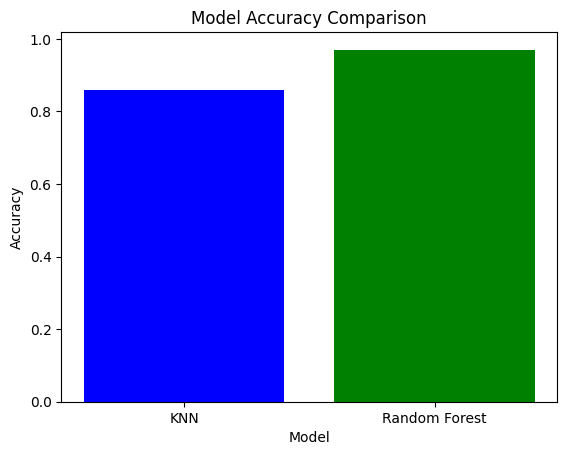

In [14]:
accuracies = {
    "KNN": acc_knn,
    "Random Forest": acc_rf
}

# رسم Bar Chart
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

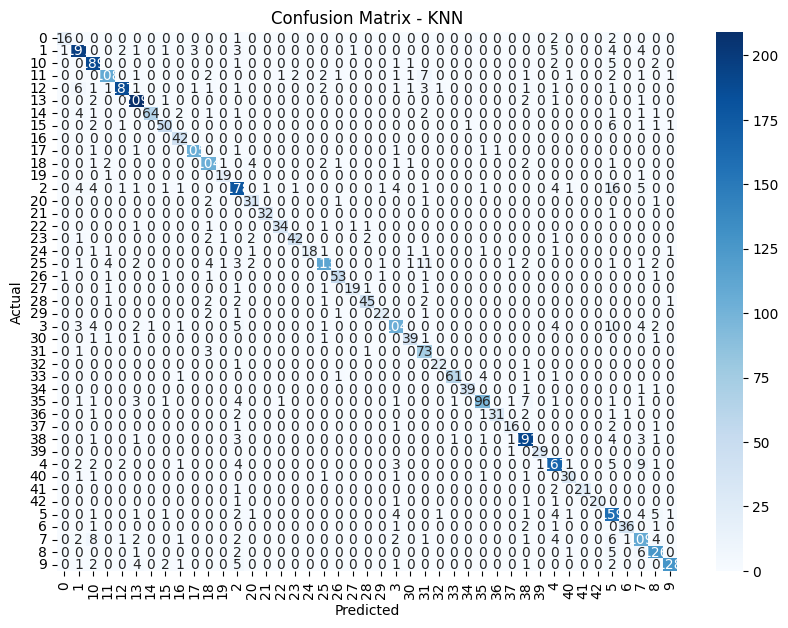

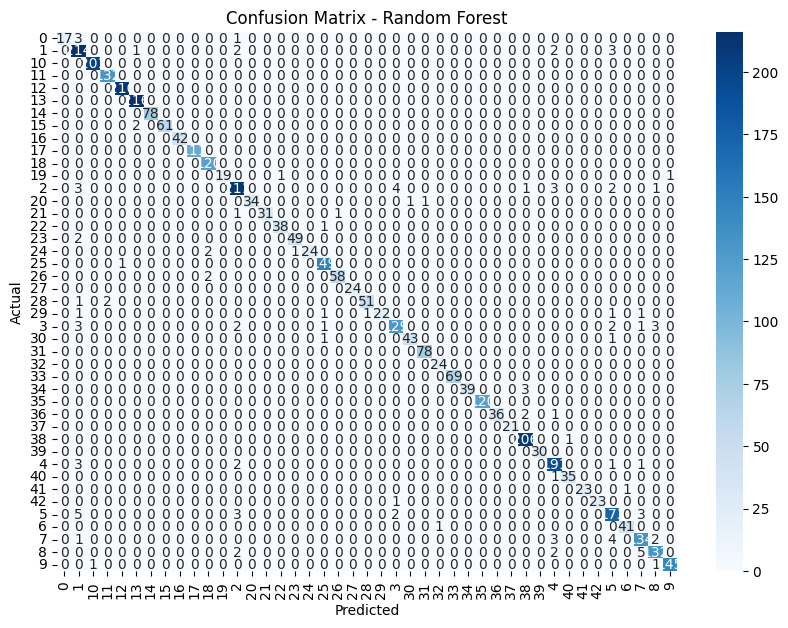

In [15]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
plot_confusion_matrix(y_val, y_val_pred_knn, 'KNN')
plot_confusion_matrix(y_val, y_val_pred_rf, 'Random Forest')
